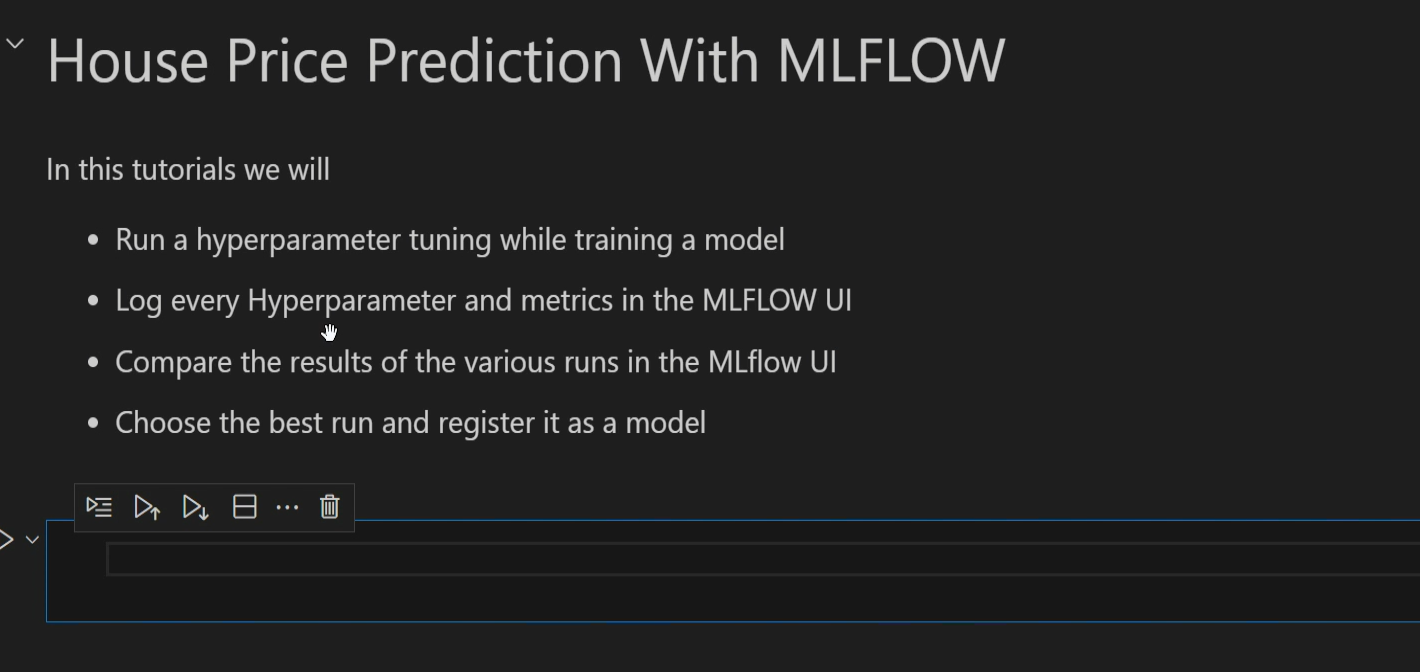

In [2]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV #GSV helps in perform all hyperparamter tuning
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_california_housing


housing = fetch_california_housing()
housing


{'data': array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
           37.88      , -122.23      ],
        [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
           37.86      , -122.22      ],
        [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
           37.85      , -122.24      ],
        ...,
        [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
           39.43      , -121.22      ],
        [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
           39.43      , -121.32      ],
        [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
           39.37      , -121.24      ]], shape=(20640, 8)),
 'target': array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894], shape=(20640,)),
 'frame': None,
 'target_names': ['MedHouseVal'],
 'feature_names': ['MedInc',
  'HouseAge',
  'AveRooms',
  'AveBedrms',
  'Population',
  'AveOccup',
  'Latitude',
  'Longitude'],
 'DESCR': 

In [4]:
# Preparing the datasets

data = pd.DataFrame(housing.data,columns=housing.feature_names)
data['Price' ] = housing.target # Price is the output
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


# Train test Split , Model Hyperparameter Tuning, MLFlow Experiments

In [10]:
from urllib.parse import urlparse # used in Mlflow experiments
# Divide data into independent and dependent features
X=data.drop(columns = ['Price'],axis=1)
y=data['Price']

In [11]:
y.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: Price, dtype: float64

# Start the Hyperparamter tuning using GridSearchCV


In [18]:
def hyperparameter_tuning(X_train,y_train,param_grid):
    rf=RandomForestRegressor()
    grid_search = GridSearchCV(estimator =rf,param_grid=param_grid,cv=3,n_jobs=-1,verbose=2,scoring='neg_mean_squared_error')

    grid_search.fit(X_train,y_train)
    return grid_search


In [20]:
from urllib.parse import urlparse
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

# Set the MLflow Tracking URI BEFORE starting the run
mlflow.set_tracking_uri(uri='http://127.0.0.1:5000')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Infer the signature
signature = infer_signature(X_train, y_train)

# Define hyperparameter tuning function
def hyperparameter_tuning(X_train, y_train, param_grid):
    rf = RandomForestRegressor()
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=3,
        n_jobs=-1,
        verbose=2,
        scoring='neg_mean_squared_error'
    )
    grid_search.fit(X_train, y_train)
    return grid_search

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

# Start MLflow run
with mlflow.start_run():

    # Run hyperparameter tuning
    grid_search = hyperparameter_tuning(X_train, y_train, param_grid)

    best_model = grid_search.best_estimator_

    # Evaluate model
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    # Log hyperparameters
    mlflow.log_param("best_n_estimators", grid_search.best_params_['n_estimators'])
    mlflow.log_param("best_max_depth", grid_search.best_params_['max_depth'])
    mlflow.log_param("best_min_samples_split", grid_search.best_params_['min_samples_split'])
    mlflow.log_param("best_min_samples_leaf", grid_search.best_params_['min_samples_leaf'])

    # Log metrics
    mlflow.log_metric('mse', mse)

    # Get tracking URI scheme
    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

    # Log the model
    if tracking_url_type_store != 'file':
        mlflow.sklearn.log_model(
            best_model,
            'Model',
            registered_model_name='Best_RandomForest_Model',
            signature=signature
        )
    else:
        mlflow.sklearn.log_model(best_model, 'model', signature=signature)

    print(f'Best hyperparameters: {grid_search.best_params_}')
    print(f'Mean Squared Error: {mse}')


Fitting 3 folds for each of 24 candidates, totalling 72 fits


2025/05/28 11:23:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RestException: RESOURCE_DOES_NOT_EXIST: Run '6811adaa18864e08a4e544601c8d286f' not found

In [17]:
print(mlflow.get_tracking_uri())

file:///c:/Users/arunshukla/OneDrive%20-%20Nagarro/Desktop/MLOps_Udemy/MLFlow_Starter/HousePrediction/mlruns
